<a href="https://colab.research.google.com/github/risker93/Hello_World/blob/main/2021_06_10_%EC%BA%90%EA%B8%80%EC%A0%84_%EC%88%98%EC%97%85_%EB%B9%84%ED%8A%B8%EC%BD%94%EC%9D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import pandas as pd
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

우리는 학자가 아니다. 구현만 되게 하면 된다.

복붙으로 인사이트를 얻어보자

In [3]:
raw_all = pd.read_csv('Bitcoin.csv', index_col='Date')
raw_all.index = pd.to_datetime(raw_all.index)
raw_all.head()

,BTC-USD
Date,
2017-01-01,998.325012
2017-01-02,1021.750000
2017-01-03,1043.839966
2017-01-04,1154.729980
2017-01-05,1013.380005


In [5]:
raw_all.tail()

,BTC-USD
Date,
2020-10-27,13654.21875
2020-10-28,13271.28516
2020-10-29,13437.88281
2020-10-30,13546.52246
2020-10-31,13780.99512


비트코인 같은 데이터는 MACD를 이용하는데

그래프 선이 봉이 나온 이후에 그려지는데 이 예측을 최대한 앞당길수 있지 않을까?

에서 나온것.

In [6]:
raw_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1400 entries, 2017-01-01 to 2020-10-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BTC-USD  1400 non-null   float64
dtypes: float64(1)
memory usage: 21.9 KB


In [7]:
raw_all.describe()

,BTC-USD
count,1400.000000
mean,7009.430287
std,3479.080257
min,777.757019
25%,4045.500976
50%,7247.584473
75%,9388.309815
max,19497.400390


In [8]:
# Parameters
criteria = '2020-01-01' 
scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.StandardScaler()
# scaler = preprocessing.RobustScaler()
sequence = 60
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0


시계열에서 트레인 데이터를 나누는 방법에 대해 알아보자

In [9]:
train = raw_all.loc[raw_all.index < criteria, :] #왼쪽이 행, 컴마 이후 :은 열
test = raw_all.loc[raw_all.index >= criteria, :]
print('Train_size:', train.shape, 'Test_size', test.shape)

Train_size: (1095, 1) Test_size (305, 1)


딥러닝에서는 데이터의 형 변환이 아주 중요하다.

형 변환이 잘 되었나 확인해 보아라

In [10]:
#scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

스케일링은 이렇게 한다

In [11]:
train

,BTC-USD
Date,
2017-01-01,998.325012
2017-01-02,1021.750000
2017-01-03,1043.839966
2017-01-04,1154.729980
2017-01-05,1013.380005
...,...
2019-12-27,7290.088379
2019-12-28,7317.990234
2019-12-29,7422.652832


In [38]:
train_scaled

array([[0.0117827 ],
       [0.01303406],
       [0.0142141 ],
       ...,
       [0.35496915],
       [0.34804285],
       [0.34273314]])

In [42]:
train_scaled.max()

1.0

In [14]:
## X / Y Split
X_train, Y_train = [], []  #파이썬은 이렇게 된다, 컴마 있으면 당연히 들어가는게 아닌가? 이렇게 생각해라.
for index in range(len(train_scaled) - sequence): # 1035 (1095에서 -60을 한값) 아 이런 숫자가 들어가는구나 인덱스는 0부터 1034까지 들어가겠구나.
#이 시퀀스의 값 60은 이정도면 되겠다 하는 임의의 값.
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence]) # 이 y의 값은 x 가 0일때 0+60 , 쭉쭉쭉
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])


In [45]:
len(X_train[0])

60

이러한 것도 있고 다른것도 있다.

반드시 비교를 하면서 진행하면 된다.

In [19]:
# Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

X_train: (1035, 60, 1) Y_train: (1035, 1)
X_test: (245, 60, 1) Y_test: (245, 1)


딥러닝 같은 경우 복붙을 주로 하기 때문에 항상 프린트를 찍어줘서 확인을 한다

In [50]:
X_train.shape

(1035, 60, 1)

In [47]:
X_train.shape[0]

1035

In [48]:
X_train.shape[1]

60

In [20]:
# 다층 퍼셉트론(multi-layer perceptron, MLP)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)


X_train: (1035, 60) Y_train: (1035, 1)
X_test: (245, 60) Y_test: (245, 1)


In [51]:
X_train.shape[1]

60

In [21]:
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               7808      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [22]:
model_fit = model.fit(X_train, Y_train,
                      batch_size=batch_size,
                      epochs=epoch,
                      verbose=verbose)

Epoch 1/10
33/33 [==============================] - 14s 2ms/step - loss: 0.0336
Epoch 2/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 3/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 4/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 5/10
33/33 [==============================] - 0s 2ms/step - loss: 9.8547e-04
Epoch 6/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 7/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 8/10
33/33 [==============================] - 0s 2ms/step - loss: 8.6843e-04
Epoch 9/10
33/33 [==============================] - 0s 2ms/step - loss: 7.3312e-04
Epoch 10/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0018


In [23]:
model_fit.history

{'loss': [0.012583485804498196,
  0.002480348339304328,
  0.001590471831150353,
  0.0011326237581670284,
  0.0010057911276817322,
  0.0010279894340783358,
  0.0009180939523503184,
  0.0007530459552071989,
  0.0007517871563322842,
  0.0016602111281827092]}

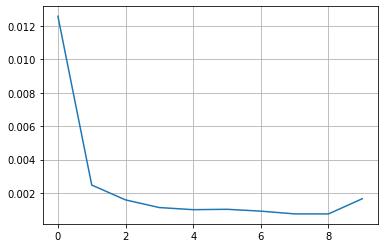

In [24]:
plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()


모델 학습을 했으니 테스트 값을 가지고 예측을 해보도록 하자


In [26]:
# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

In [27]:
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual


def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te


In [30]:
result= model.evaluate(X_test, Y_test_pred)

8/8 [==============================] - 1s 2ms/step - loss: 98020776.0000


,MAE,MSE,MAPE
Train,204.694244,83843.214968,2.530360
Test,437.783514,394119.160239,5.422766


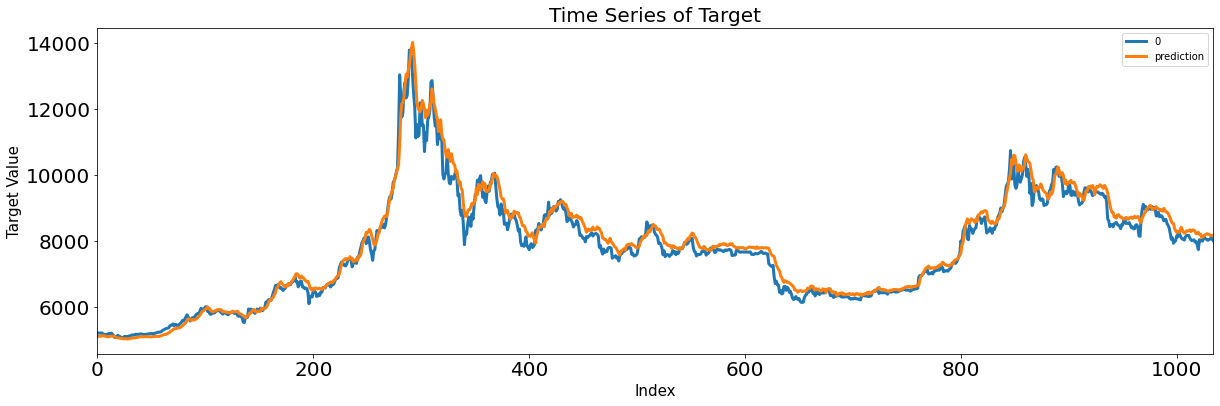

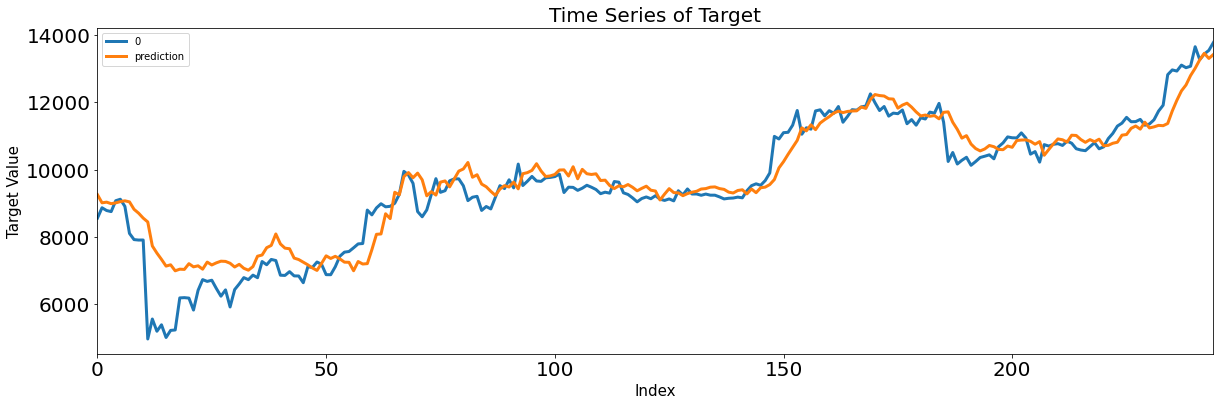

In [29]:
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_MLP, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_MLP)



Train_size: (1095, 1) Test_size: (305, 1)
X_train: (1035, 60, 1) Y_train: (1035, 1)
X_test: (245, 60, 1) Y_test: (245, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 60, 128)           16640     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 60, 256)           98560     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 60, 128)           49280     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 128)           0        

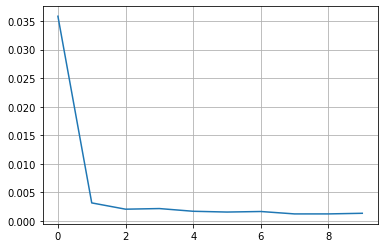

8/8 [==============================] - 2s 30ms/step - loss: 1.6676e-15


,MAE,MSE,MAPE
Train,386.769222,362807.685576,6.090724
Test,339.657517,272321.229048,4.044572


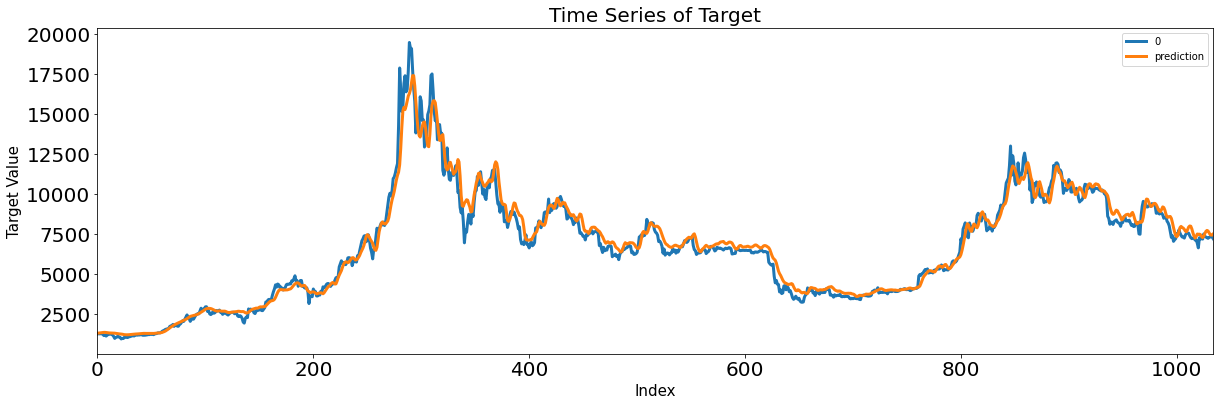

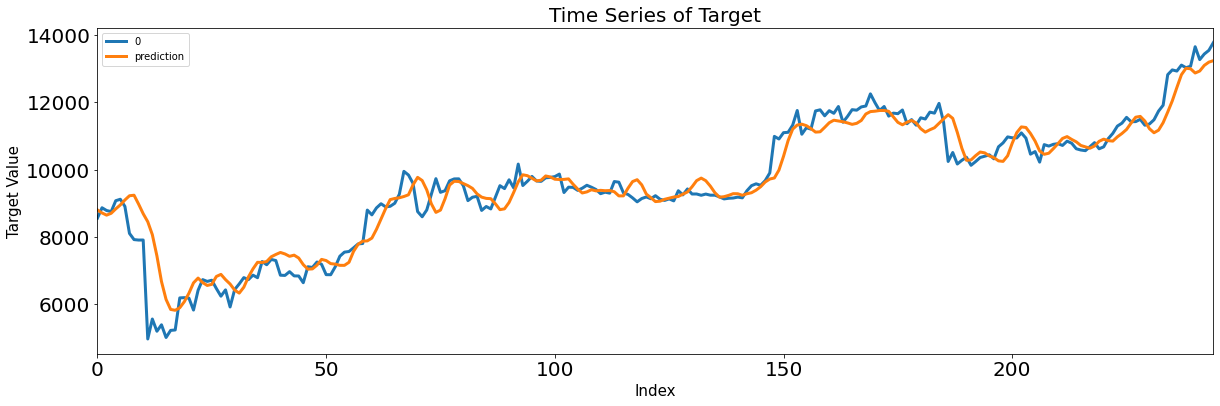

In [31]:
# RNN
location = 'Bitcoin.csv'
raw_all = pd.read_csv(location, index_col='Date')
raw_all.index = pd.to_datetime(raw_all.index)

# Parameters
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = raw_all.loc[raw_all.index < criteria,:]
test = raw_all.loc[raw_all.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# RNN
model = Sequential()
model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_RNN, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_RNN)
